In [1]:
import pdb
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import glob
import natsort
from pynwb import NWBHDF5IO
from ndx_events import LabeledEvents, AnnotatedEventsTable, Events

In [2]:
lp = '/data2/users/stepeter/files_nwb/downloads/000055/'
nparts = 12

genders = ['M', 'M', 'M', 'F', 'F', 'M', 'M', 'F', 'M', 'M', 'F', 'M']
ages = [44, 20, 33, 19, 31, 37, 26, 33, 20, 34, 34, 22]

In [3]:
def identify_elecs(group_names):
    '''Utility function to determine surface v. depth ECoG electrodes'''
    is_surf = []
    for label in group_names:
        if 'grid' in label.lower():
            is_surf.append(True)
        elif label.lower() in ['mhd', 'latd', 'lmtd', 'ltpd']:
            is_surf.append(True)  # special cases
        elif (label.lower() == 'ahd') & ('PHD' not in group_names):
            is_surf.append(True)  # special case
        elif 'd' in label.lower():
            is_surf.append(False)
        else:
            is_surf.append(True)
    return np.array(is_surf)

In [4]:
n_elecs_tot, n_elecs_good = [], []
rec_days, hemis, n_elecs_surf, n_elecs_depth = [], [], [], []
for part_ind in tqdm(range(nparts)):
    cur_t = 0
    fids = natsort.natsorted(glob.glob(lp+'sub-'+str(part_ind+1).zfill(2)+'/*.nwb'))
    rec_days.append(len(fids))
    for fid in fids[:1]:
        io = NWBHDF5IO(fid, mode='r', load_namespaces=False)
        nwb = io.read()
        
        # Determine good/total electrodes
        n_elecs_good.append(np.sum(nwb.electrodes['good'][:]))
        n_elecs_tot.append(len(nwb.electrodes['good'][:]))
        
        # Determine implanted hemisphere
        c_wrist = nwb.processing['behavior'].data_interfaces['ReachEvents'].description[0]
        hemis.append('L' if c_wrist == 'r' else 'R')
        
        # Determine surface vs. depth electrode count
        is_surf = identify_elecs(nwb.electrodes['group_name'][:])
        n_elecs_surf.append(np.sum(is_surf))
        n_elecs_depth.append(np.sum(1-is_surf))
        
part_nums = [val+1 for val in range(nparts)]
part_ids = ['P'+str(val).zfill(2) for val in part_nums]

## Participant characteristics table

In [5]:
cols = ['Participant', 'Gender', 'Age\n(years)', 'Recording\ndays used',
        'Hemisphere \nimplanted', '# surface\nelectrodes', '# depth\nelectrodes']
df = pd.DataFrame([part_ids, genders, ages, rec_days, hemis,
                   n_elecs_surf, n_elecs_depth],
                   index=cols).T
print(df.to_string(index=False))

Participant Gender Age\n(years) Recording\ndays used Hemisphere \nimplanted # surface\nelectrodes # depth\nelectrodes
        P01      M           44                    4                      L                    86                   8
        P02      M           20                    4                      R                    70                  16
        P03      M           33                    4                      L                    80                  16
        P04      F           19                    5                      R                    84                   0
        P05      F           31                    3                      R                   106                   0
        P06      M           37                    5                      L                    80                   0
        P07      M           26                    5                      R                    64                   0
        P08      F           33                    5    

<ipython-input-6-51fbbc095411>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(part_ids, rotation=45)


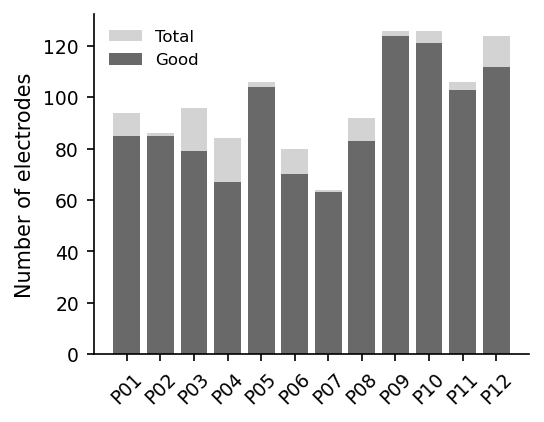

In [6]:
fig = plt.figure(figsize=(3.75, 3), dpi=150)
plt.bar(part_ids,n_elecs_tot,color='lightgrey')
plt.bar(part_ids,n_elecs_good,color='dimgrey')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().set_xticklabels(part_ids, rotation=45)
plt.legend(['Total','Good'], frameon=False, fontsize=8)
plt.tick_params(labelsize=9)
plt.ylabel('Number of electrodes')

# fig_sp = '/data1/users/stepeter/mvmt_init/figs/'
# fig_name = 'good_bad_elecs'
# dpi_plt = 300
# fig.savefig(fig_sp+fig_name+'.png',
#             format='png',transparent= True,dpi=dpi_plt,
#             bbox_inches = 'tight', pad_inches = 0.01,
#             )
plt.show()


In [7]:
print(np.array(n_elecs_tot).min())
print(np.array(n_elecs_tot).max())

64
126


In [8]:
n_elecs_bad = np.array([n_elecs_tot[i]-n_elecs_good[i] for i in range(nparts)])
print(n_elecs_bad.mean().round(1))
print(n_elecs_bad.std().round(1))

7.3
5.6
